In [1]:
%load_ext autoreload
%autoreload 2

# Validation of analyses

Only for the first night for simplicity

In [2]:
import os,sys,glob

import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from scipy import stats 

from gammapy.datasets import Dataset, Datasets
from gammapy.modeling.models import (
    SkyModel,
    Models,
    TemplateSpectralModel,
    EBLAbsorptionNormSpectralModel,
    GaussianPrior,
    UniformPrior,
    PowerLawSpectralModel,
    SmoothBrokenPowerLawSpectralModel,
)

### Custom code
helpers = os.path.abspath('../Helpers')
if helpers not in sys.path:
    sys.path.append(helpers)
from hydrogen import (
    get_tbabs_template_model,
)
from dustextinction import (
    get_xredden_template_model,
)
from utils import (
    get_dataset_energy_edges,
    get_dataset_energy_edges_from_aeff_integral,
    get_weighted_mean_energy_from_aeff,
    draw_sed_contours,
)
from gammapy.estimators import FluxPointsEstimator
from gammapy.modeling import Fit, Covariance

from astropy.table import Table,vstack
from astropy.coordinates import SkyCoord
from scipy.interpolate import RectBivariateSpline

import matplotlib as mpl
from gammapy.modeling import Covariance

import pygtc
import logging
from gammapy.modeling import Parameters
from matplotlib.patches import Ellipse
import matplotlib.ticker as mticker
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from scipy.stats import chi2

In [3]:
from astropy.constants import h, c

# Function to convert energy (eV) to wavelength (nm)
def energy_to_wavelength_eV(E):
    return (h.to('eV s').value * c.to('AA s-1').value) / E  # wavelength in AA

# Function to convert wavelength (nm) to energy (eV)
def wavelength_to_energy_eV(lambda_AA):
    return (h.to('eV s').value * c.to('AA s-1').value * 1e9) / lambda_AA  # energy in eV


In [4]:
basedir     = os.path.abspath("../")

## Fermi-LAT 
(Gammapy vs Fermitools)

In [5]:
datasetdir  = f"{basedir}/LAT/MJD60373/"
# assuming we start from the Notebooks directory
fermi_datasets = Datasets.read(f"{datasetdir}/dataset.yaml")
fermi_datasets.models = list(Models.read(f"{datasetdir}/models.yaml"))

# Our covariance and best-fit parameter file is referenced at 1 GeV
ebl_absorption_model = EBLAbsorptionNormSpectralModel.read(
    f"{basedir}/Models/ebl_dominguez11.fits.gz",redshift=0.997,alpha_norm=1)
fermi_datasets.models['OP313'].spectral_model *= ebl_absorption_model

/home/mnievas/anaconda/envs/ciaoxray_devel/lib/python3.11/site-packages/gammapy/utils/scripts.py:66: UserWarning: Checksum verification failed.
  warnings.warn("Checksum verification failed.", UserWarning)
Parameter 'value' not defined in YAML file. Using default value: 1.0 sr-1


In [6]:
### Reference bow-tie SED from Fermitools/enrico and flux points computed with enrico
enrico_bowtie = Table.read(f"{datasetdir}/SED_OP313_PowerLaw.dat",format='ascii',
                           names=['energy','e2dnde','e2dnde_err'],
                           units=['MeV','erg/cm2/s','erg/cm2/s'])
enrico_fluxpoints = Table.read(
    f"{datasetdir}/SED_OP313_PowerLaw.Ebin.dat",format='ascii',
    names=['energy','emin','emax','e2dnde','e2dnde_err','e2dnde_errn','e2dnde_errp'],
    units=['MeV','MeV','MeV','erg/cm2/s','erg/cm2/s','erg/cm2/s','erg/cm2/s'])

In [7]:
# Define a fit
fermi_only_fit    = Fit(store_trace=True)
fermi_only_result = fermi_only_fit.run(fermi_datasets)
# we make a copy here for later comparisons
fermi_only_model = fermi_datasets.models.copy()
# spectral points
energy_edges = np.asarray(list(enrico_fluxpoints['emin']) + [enrico_fluxpoints['emax'][-1]])*u.MeV
fermi_only_fpe = FluxPointsEstimator(energy_edges=energy_edges, source="OP313", selection_optional="all", 
                                     n_sigma_ul=np.sqrt(stats.norm.isf(0.5 * 0.05)))
fermi_only_points = fermi_only_fpe.run(fermi_datasets).copy()

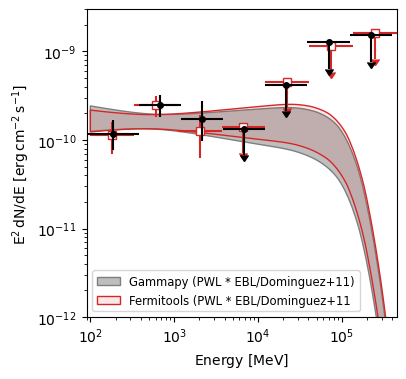

In [8]:
def calculate_assym_errors(cen,err,unit = 'erg/(cm*cm*s)'):
    import astropy.units as u
    units = u.Unit(unit)
    cen = cen.to(unit).value
    err = err.to(unit).value
    ypos = cen+err
    yneg = 10**(2*np.log10(cen)-np.log10(cen+err))
    return(cen*units,yneg*units,ypos*units)

fig = plt.figure(figsize=(4, 4),dpi=100)

ax = fermi_only_points.plot(
    color="black", sed_type='e2dnde',
    zorder=10,
)

draw_sed_contours(ax=ax,model=fermi_only_model['OP313'].spectral_model,energy_edges=energy_edges,color='tab:gray',
                  label='Gammapy (PWL * EBL/Dominguez+11)')
draw_sed_contours(ax=ax,model=None,
                  x=enrico_bowtie['energy'],
                  y=enrico_bowtie['e2dnde'],
                  yerr=enrico_bowtie['e2dnde_err'],
                  energy_edges=energy_edges,color='tab:red',
                  facealpha=0.1,
                  label='Fermitools (PWL * EBL/Dominguez+11')
xlims = ax.get_xlim()
ylims = ax.get_ylim()

enrico_fluxpoints = enrico_fluxpoints[enrico_fluxpoints['e2dnde']>0]
uplims = enrico_fluxpoints['e2dnde_errp']==0
ax.errorbar(
    x = enrico_fluxpoints['energy'],
    xerr = [enrico_fluxpoints['energy']-enrico_fluxpoints['emin'],
            enrico_fluxpoints['emax']-enrico_fluxpoints['energy']],
    y = enrico_fluxpoints['e2dnde'],#+uplims*1.2*enrico_fluxpoints['e2dnde'],
    yerr = [enrico_fluxpoints['e2dnde_errn']+uplims*(enrico_fluxpoints['e2dnde']*0.5),
            enrico_fluxpoints['e2dnde_errp']],
    uplims=uplims,
    ls='None',
    marker='s',
    color='tab:red',
    mfc='white',
)

#ax.set_title('$Fermi$-LAT analysis')
ax.legend(fontsize='small')
from matplotlib.ticker import ScalarFormatter
ax.set_ylim(1e-12,0.3e-8)
ax.set_xlim(0.9e2,4.5e5)
ax.set_ylabel('$\mathrm{E^2\,dN/dE}$ $\mathrm{[erg\,cm^{-2}\,s^{-1}]}$')

!mkdir -p {basedir}/Figures/MJD60373/Fermi-LAT/
fig.savefig(f"{basedir}/Figures/MJD60373/Fermi-LAT/BestFit_Fermi-LAT_fermitools_gammapy.pdf",bbox_inches='tight')

In [9]:
# Function to read the parameter matrix file
def read_parameter_matrix(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    param_data_lines = lines[3:]
    par_names, values, errors, scales = [], [], [], []
    for line in param_data_lines:
        par_name, value, error, scale = line.strip().split(',')
        par_names.append(par_name.strip())
        values.append(float(value))
        errors.append(float(error))
        scales.append(float(scale))

    param_data = {
        'Par Name': par_names,
        'Value': values,
        'Error': errors,
        'Scale': scales
    }

    return Table(param_data)

# Function to read the covariance matrix file
def read_covariance_matrix(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    param_names = [line.strip().replace('#', '') for line in lines[2:4]]
    cov_data_lines = lines[5:]
    cov_data = []
    for line in cov_data_lines:
        cov_data.append([float(x) for x in line.strip().split(',')])

    cov_matrix = np.array(cov_data)
    return param_names, cov_matrix

# Read the files and create the tables

param_file_path=f"{datasetdir}/SED_OP313_PowerLaw.fitpars.dat"
cov_file_path=f"{datasetdir}/SED_OP313_PowerLaw.cov.dat"
param_table = read_parameter_matrix(param_file_path)
param_names, cov_matrix = read_covariance_matrix(cov_file_path)

# Extract parameter values and errors
norm = param_table['Value'][0] #* 1e-12
norm_err = param_table['Error'][0] #* 1e-12
alpha = param_table['Value'][1]
alpha_err = param_table['Error'][1]
Eb = param_table['Value'][3]  # Reference energy

# Adjust the covariance matrix for the scaling factor
scaling_factor = 1e-12
cov_matrix[0, 0] *= scaling_factor**2
cov_matrix[0, 1] *= scaling_factor
cov_matrix[1, 0] *= scaling_factor

full_cov_matrix = np.zeros((3, 3))
full_cov_matrix[1, 1] = cov_matrix[0, 0]
full_cov_matrix[1, 0] = cov_matrix[0, 1]
full_cov_matrix[0, 1] = cov_matrix[1, 0]
full_cov_matrix[0, 0] = cov_matrix[1, 1]

# Create the PowerLaw model
model_enrico = PowerLawSpectralModel(
    amplitude=norm * u.Unit('cm-2 s-1 MeV-1'),
    index=alpha,
    reference=Eb * u.Unit('MeV'),
    covariance = full_cov_matrix
)

model_enrico.parameters['amplitude'].error = norm_err
model_enrico.parameters['amplitude'].scale = 1e-12
model_enrico.parameters['index'].error = alpha_err

# Create the Covariance object and assign the data
covariance = Covariance(model_enrico.parameters)
covariance.data = full_cov_matrix

# Assign the covariance matrix to the model parameters
model_enrico.covariance = covariance

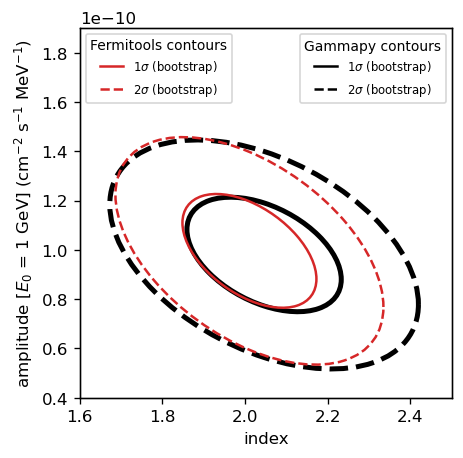

In [10]:


def get_samples(model,N=30000):
    free_pars = model.covariance.parameters.free_parameters
    free_pars = [p for k,p in enumerate(free_pars) if free_pars[k].name]
    free_pars = Parameters(free_pars)
    cov = model.covariance.get_subcovariance(free_pars)
    covm = cov.data
    labl = cov.parameters.names
    mean = cov.parameters.value
    return(np.random.multivariate_normal(mean, covm, N),mean,labl)

def get_confidence_ellipse(samples,sigmas=1):
    x,y = samples[0].transpose()
    # Compute mean and covariance matrix
    mean = np.mean(np.vstack((x, y)), axis=1)
    cov_matrix = np.cov(x, y)
    confidence_level = chi2.cdf(sigmas**2,df=1)
    chi2_val = chi2.ppf(confidence_level, df=1)  # df=2 for 2 dimensions (X, Y)
    sigmas = np.sqrt(chi2_val)
    #print(sigma)
    
    # Eigen decomposition of covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    angle = -np.degrees(np.arctan2(*eigenvectors[:, 1]))
    width, height = 2 * sigmas * np.sqrt(eigenvalues)

    result = {'mean': mean, 'chi2_val': chi2_val, 'sigma': sigmas, 'angle': angle, 'width': width, 'height': height}
    return(result)


# Plotting the data points and contours

fig, ax = plt.subplots(figsize=(4,4),dpi=120)
ax2 = ax.twinx()

#### Gammapy

samples = get_samples(fermi_datasets.models['OP313'].spectral_model)
ellipse_1 = get_confidence_ellipse(samples,1)
ellipse_2 = get_confidence_ellipse(samples,2)

# Plot the 1-sigma contour
ellipse1 = Ellipse(xy=ellipse_1['mean'], 
                   width=ellipse_1['width'], 
                   height=ellipse_1['height'], 
                   angle=ellipse_1['angle'],
                   edgecolor='black', fc='None', ls='solid',
                   lw=3, label='1$\\sigma$ (bootstrap)')

ellipse2 = Ellipse(xy=ellipse_2['mean'], 
                   width=ellipse_2['width'], 
                   height=ellipse_2['height'], 
                   angle=ellipse_2['angle'], ls='dashed',
                   edgecolor='black', fc='None', 
                   lw=3, label='2$\\sigma$ (bootstrap)')



ax.add_patch(ellipse1)
ax.add_patch(ellipse2)

# Plot mean point

#### Enrico / fermitools

model = model_enrico
samples = get_samples(model)
ellipse_1 = get_confidence_ellipse(samples,1)
ellipse_2 = get_confidence_ellipse(samples,2)

# Plot the 1-sigma contour
ellipse1 = Ellipse(xy=ellipse_1['mean'], 
                   width=ellipse_1['width'], 
                   height=ellipse_1['height'], 
                   angle=ellipse_1['angle'],
                   edgecolor='C3', fc='None', 
                   lw=1.5, label='1$\\sigma$ (bootstrap)')

ellipse2 = Ellipse(xy=ellipse_2['mean'], 
                   width=ellipse_2['width'], 
                   height=ellipse_2['height'], 
                   angle=ellipse_2['angle'],
                   edgecolor='C3', fc='None', ls='dashed',
                   lw=1.5, label='2$\\sigma$ (bootstrap)')


ax2.add_patch(ellipse1)
ax2.add_patch(ellipse2)

# Set labels and legend
ax.set_xlabel('index')
ax.set_ylabel('amplitude [$E_0$ = 1 GeV] (cm$^{-2}$ s$^{-1}$ MeV$^{-1}$)')

# Custom legend entries for ellipses
gammapy_1sigma = mlines.Line2D([], [], color='black', linestyle='solid', label='1$\\sigma$ (bootstrap)')
gammapy_2sigma = mlines.Line2D([], [], color='black', linestyle='dashed', label='2$\\sigma$ (bootstrap)')
fermitools_1sigma = mlines.Line2D([], [], color='C3', linestyle='solid', label='1$\\sigma$ (bootstrap)')
fermitools_2sigma = mlines.Line2D([], [], color='C3', linestyle='dashed', label='2$\\sigma$ (bootstrap)')

legend1 = ax.legend(ncol=1,fontsize='7', loc='upper right', title=r'Gammapy contours',
                    title_fontsize='small')
legend2 = ax2.legend(ncol=1,fontsize='7', loc='upper left', title=r'Fermitools contours',
                     title_fontsize='small')


legend_handles1,legend_text1 = ax.get_legend_handles_labels()
legend_handles1[0] = gammapy_1sigma
legend_handles1[1] = gammapy_2sigma

legend_handles2,legend_text2 = ax2.get_legend_handles_labels()
legend_handles2[0] = fermitools_1sigma
legend_handles2[1] = fermitools_2sigma

legend1.remove()
legend2.remove()

legend1 = ax.legend(handles=legend_handles1, ncol=1,fontsize='7', loc='upper right', 
                    title=r'Gammapy contours',
                    title_fontsize='small')
legend2 = ax2.legend(handles=legend_handles2, ncol=1,fontsize='7', loc='upper left', 
                     title=r'Fermitools contours',
                     title_fontsize='small')


#plt.title(,fontsize='medium')
#plt.grid(True, ls='dotted')
#plt.axis('equal')
ax.set_ylim([0.4e-10,1.9e-10])
ax.set_xlim([1.6,2.5])
ax2.set_ylim(ax.get_ylim())
ax2.set_xlim(ax.get_xlim())
ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)

#ax.set_title('${Fermi}$-LAT best-fit parameters (PWL)')

#ax.set_yscale('log')
!mkdir -p {basedir}/Figures/MJD60373/Fermi-LAT/
fig.savefig(f"{basedir}/Figures/MJD60373/Fermi-LAT/Fermi_parameter_ellipses.pdf",bbox_inches='tight')

In [11]:
model_enrico

In [12]:
fermi_only_model['OP313'].spectral_model

# NuSTAR

(Gammapy vs xspec)

In [13]:
basedir = os.path.abspath("../")
datasetdir  = f"{basedir}/NuSTAR/MJD60373/wstat_background"

# load the dataset and models (without hydrogen-absorption), assuming we start from the Notebooks directory
nustar_datasets_wstat = Datasets.read(f"{datasetdir}/dataset.yaml")
nustar_datasets_wstat.models = list(Models.read(f"{datasetdir}/models.yaml"))

# add the hydrogen absorption from the 2D table (output from sherpa's / xspec's tbabs). It is the same for XRT.
hyd_absorpt = get_tbabs_template_model(f"{basedir}/Models/tbabs_tau_factor_vs_nH_energy.ecsv",srcname="OP313",freeze=True)
nustar_datasets_wstat.models['OP313'].spectral_model *= hyd_absorpt

/home/mnievas/anaconda/envs/ciaoxray_devel/lib/python3.11/site-packages/gammapy/utils/scripts.py:66: UserWarning: Checksum verification failed.
  warnings.warn("Checksum verification failed.", UserWarning)


In [14]:
energies = nustar_datasets_wstat['NuSTAR_A'].counts.geom.axes['energy'].edges
energies = energies[(energies>2.8*u.keV)*(energies<80*u.keV)].value
approx_ebins = np.geomspace(min(energies),max(energies),9)
approx_ebins = np.asarray([energies[np.argmin(np.abs(energies-E))] for E in approx_ebins])*u.keV

In [15]:
# Define a fit
nustar_only_fit_wstat    = Fit(store_trace=True)
nustar_only_result_wstat = nustar_only_fit_wstat.run(nustar_datasets_wstat)
# we make a copy here for later comparisons
nustar_only_model_wstat  = nustar_datasets_wstat.models.copy()
# spectral points
energy_edges_wstat       = approx_ebins # np.geomspace(3*u.keV, 80*u.keV, 8)
nustar_only_fpe_wstat    = FluxPointsEstimator(energy_edges=energy_edges_wstat, source="OP313", n_sigma_ul=np.sqrt(stats.norm.isf(0.5 * 0.05)), selection_optional="all")
nustar_only_points_wstat = nustar_only_fpe_wstat.run(nustar_datasets_wstat).copy()

In [16]:
basedir = os.path.abspath("../")
datasetdir  = f"{basedir}/NuSTAR/MJD60373/"

# load the dataset and models (without hydrogen-absorption), assuming we start from the Notebooks directory
nustar_datasets = Datasets.read(f"{datasetdir}/dataset.yaml")
nustar_datasets.models = list(Models.read(f"{datasetdir}/models.yaml"))
nustar_datasets.models['NuSTAR_A-bkg'].parameters['norm'].value = 1
nustar_datasets.models['NuSTAR_B-bkg'].parameters['norm'].value = 1

# add the hydrogen absorption from the 2D table (output from sherpa's / xspec's tbabs). It is the same for XRT.
hyd_absorpt = get_tbabs_template_model(f"{basedir}/Models/tbabs_tau_factor_vs_nH_energy.ecsv",srcname="OP313",freeze=True)
nustar_datasets.models['OP313'].spectral_model *= hyd_absorpt

/home/mnievas/anaconda/envs/ciaoxray_devel/lib/python3.11/site-packages/gammapy/utils/scripts.py:66: UserWarning: Checksum verification failed.
  warnings.warn("Checksum verification failed.", UserWarning)
HDU 'PSF' not found
HDU 'PSF' not found


## Gammapy joint A+B analysis (with instrumental background)

In [17]:
# Define a fit
nustar_only_fit    = Fit(store_trace=True)
nustar_only_result = nustar_only_fit.run(nustar_datasets)
# we make a copy here for later comparisons
nustar_only_model  = nustar_datasets.models.copy()
# spectral points
energy_edges       = approx_ebins #np.geomspace(3*u.keV, 80*u.keV, 8)
nustar_only_fpe    = FluxPointsEstimator(energy_edges=energy_edges, source="OP313", n_sigma_ul=np.sqrt(stats.norm.isf(0.5 * 0.05)), selection_optional="all")
nustar_only_points = nustar_only_fpe.run(nustar_datasets).copy()

HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found


## Native joint A+B fit with xspec (with instrumental background)

In [18]:
xspec_model = nustar_datasets.models[0].copy()
xspec_model.parameters['index'].value = 1.63346
xspec_model.parameters['index'].error = 2.95757E-02
xspec_model.parameters['amplitude'].value = 6.29640E-04
xspec_model.parameters['amplitude'].error = 1.16802E-05

xspec_model._covariance._data[0][0] = 1.364e-10
xspec_model._covariance._data[0][1] = -1.254e-07
xspec_model._covariance._data[1][0] = -1.254e-07
xspec_model._covariance._data[1][1] = 8.747e-04
xspec_model.covariance = Covariance(xspec_model._covariance.parameters,xspec_model._covariance._data)

## Compare SEDs

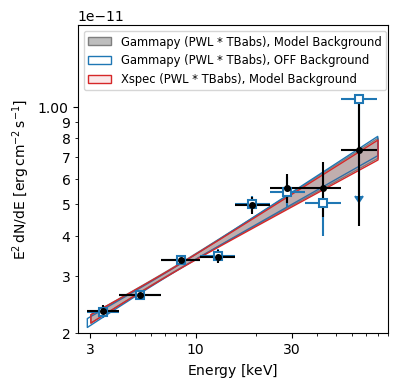

In [19]:
def calculate_assym_errors(cen,err,unit = 'erg/(cm*cm*s)'):
    import astropy.units as u
    units = u.Unit(unit)
    cen = cen.to(unit).value
    err = err.to(unit).value
    ypos = cen+err
    yneg = 10**(2*np.log10(cen)-np.log10(cen+err))
    return(cen*units,yneg*units,ypos*units)

fig = plt.figure(figsize=(4, 4),dpi=100)

# Create an invisible plot to generate the axes (needs to be done once)
energy_edges = [3*u.keV,80*u.keV]
ax = nustar_only_model['OP313'].spectral_model.plot_error(
    [energy_edges[0],energy_edges[-1]],
    facecolor='None',
    sed_type='e2dnde'
)

draw_sed_contours(ax=ax,model=nustar_only_model['OP313'].spectral_model,
                  energy_edges=energy_edges,color='tab:gray',
                  label='Gammapy (PWL * TBabs), Model Background')
draw_sed_contours(ax=ax,model=nustar_only_model_wstat['OP313'].spectral_model,
                  energy_edges=energy_edges_wstat,color='tab:blue',facealpha=0,
                  label='Gammapy (PWL * TBabs), OFF Background')
draw_sed_contours(ax=ax,model=xspec_model.spectral_model,
                  energy_edges=energy_edges,color='tab:red',
                  facealpha=0.1,label='Xspec (PWL * TBabs), Model Background')

xlims = ax.get_xlim()
ylims = ax.get_ylim()

nustar_only_points_wstat.plot(
    ax=ax, color="tab:blue", marker='s',sed_type='e2dnde', markersize=6,markerfacecolor='white',markeredgewidth=1.5,
    zorder=2,
)

nustar_only_points.plot(
    ax=ax, color="black", sed_type='e2dnde',
    zorder=2,
)

#ax.set_title('NuSTAR A+B analysis')
ax.legend(fontsize='small',loc=2)
#ax.ticklabel_format(useOffset=True)
from matplotlib.ticker import ScalarFormatter
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:g}"))
#ax.yaxis.set_minor_formatter(mpl.ticker.StrMethodFormatter("{x:g}"))
#ax.yaxis.set_major_formatter(ScalarFormatter())
#ax.yaxis.set_minor_formatter(ScalarFormatter()) 
ax.xaxis.set_major_formatter(ScalarFormatter())
#ax.ticklabel_format(axis='y', style='sci', scilimits=(0,10))   # <--- no error
ax.ticklabel_format(axis='x', style='plain')

from matplotlib.ticker import ScalarFormatter
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(ScalarFormatter()) 
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,10))   # <--- no error

ax.set_xticks([3.0,10.0,30.0,100.0])
ax.set_ylim(2e-12,1.8e-11)
ax.set_xlim(2.6,90)

ax.set_ylabel('$\mathrm{E^2\,dN/dE}$ $\mathrm{[erg\,cm^{-2}\,s^{-1}]}$')

!mkdir -p {basedir}/Figures/MJD60373/NuSTAR/
fig.savefig(f'{basedir}/Figures/MJD60373/NuSTAR/BestFit_NuSTAR_xspec_gammapy.pdf',bbox_inches='tight')

## Compare parameter contours

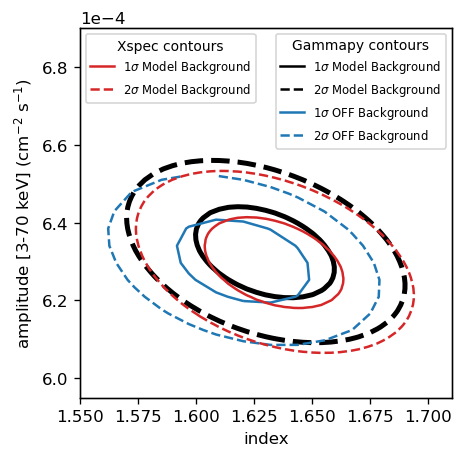

In [20]:
from scipy.stats import chi2
from astropy.table import Table
import matplotlib.lines as mlines

fig, ax = plt.subplots(figsize=(4,4),dpi=120)
ax2 = ax.twinx()

xspec_cstat = Table.read(f"{datasetdir}/crosschecks/stat_contours.dat",
                   format='ascii.no_header',
                   names=['cstat','delta_cstat','i_norm','norm','i_index','index'])

par_ampli = nustar_datasets.models.parameters["amplitude"]
par_alpha = nustar_datasets.models.parameters["index"]
par_ampli.scan_values = np.linspace(xspec_cstat['norm'].min(), xspec_cstat['norm'].max(), len(np.unique(xspec_cstat['norm'])))
par_alpha.scan_values = np.linspace(xspec_cstat['index'].min(), xspec_cstat['index'].max(), len(np.unique(xspec_cstat['index'])))

gammapy_cstat_sigma = nustar_only_fit.stat_surface(
    datasets=nustar_datasets,
    x=nustar_datasets.parameters["index"],
    y=nustar_datasets.parameters["amplitude"],
    reoptimize=True,
)
gammapy_cstat_sigma["delta_cstat"] = gammapy_cstat_sigma["stat_scan"] - nustar_only_result.total_stat

gammapy_wstat_sigma = nustar_only_fit_wstat.stat_surface(
    datasets=nustar_datasets_wstat,
    x=nustar_datasets_wstat.parameters["index"],
    y=nustar_datasets_wstat.parameters["amplitude"],
    reoptimize=False,
)
gammapy_wstat_sigma["delta_cstat"] = gammapy_wstat_sigma["stat_scan"] - nustar_only_result_wstat.total_stat

ax.contour(gammapy_cstat_sigma['OP313.spectral.model1.index_scan'],
           gammapy_cstat_sigma['OP313.spectral.model1.amplitude_scan'],
           np.transpose(gammapy_cstat_sigma["delta_cstat"]),
           levels = [chi2.ppf(chi2.cdf(k,df=1), df=1) for k in [1,4]],
           colors='black',
           linestyles=['solid','dashed'],
           linewidths=3,
)

ax.contour(gammapy_wstat_sigma['OP313.spectral.model1.index_scan'],
           gammapy_wstat_sigma['OP313.spectral.model1.amplitude_scan'],
           np.transpose(gammapy_wstat_sigma["delta_cstat"]),
           levels = [chi2.ppf(chi2.cdf(k,df=1), df=1) for k in [1,4]],
           colors='tab:blue',
           linestyles=['solid','dashed'],
           linewidths=1.5,
)

ax.tricontour(xspec_cstat['index'],xspec_cstat['norm'],xspec_cstat['delta_cstat'],
               levels = [chi2.ppf(chi2.cdf(k,df=1), df=1) for k in [1,4]],
               colors='tab:red',
               linestyles=['solid','dashed'],
               linewidths=1.5,
)

# Custom legend entries for ellipses
gammapy_1sigma = mlines.Line2D([], [], color='black', linestyle='solid', label='1$\\sigma$ Model Background')
gammapy_2sigma = mlines.Line2D([], [], color='black', linestyle='dashed', label='2$\\sigma$ Model Background')
gammapy_1sigma_wstat = mlines.Line2D([], [], color='tab:blue', linestyle='solid', label='1$\\sigma$ OFF Background')
gammapy_2sigma_wstat = mlines.Line2D([], [], color='tab:blue', linestyle='dashed', label='2$\\sigma$ OFF Background')
native_1sigma = mlines.Line2D([], [], color='tab:red', linestyle='solid', label='1$\\sigma$ Model Background')
native_2sigma = mlines.Line2D([], [], color='tab:red', linestyle='dashed', label='2$\\sigma$ Model Background')
ax.add_artist(gammapy_1sigma)
ax.add_artist(gammapy_2sigma)
ax.add_artist(gammapy_1sigma_wstat)
ax.add_artist(gammapy_2sigma_wstat)
ax2.add_artist(native_1sigma)
ax2.add_artist(native_2sigma)

ax.set_ylim([5.95e-4, 6.9e-4])
ax.set_xlim([1.55, 1.71])
ax2.set_ylim(ax.get_ylim())
ax2.set_xlim(ax.get_xlim())
ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# Set labels and legend
ax.set_xlabel('index')
ax.set_ylabel('amplitude [3-70 keV] (cm$^{-2}$ s$^{-1}$)')


legend1 = ax.legend(ncol=1,fontsize='7', loc='upper right', title=r'Gammapy contours',
                    title_fontsize='small')
legend2 = ax2.legend(ncol=1,fontsize='7', loc='upper left', title=r'Xspec contours',
                     title_fontsize='small')

#ax.set_title('NuSTAR best-fit parameters (PWL)')
!mkdir -p {basedir}/Figures/MJD60373/NuSTAR/
fig.savefig('../Figures/MJD60373/NuSTAR/StatContours_NuSTAR__xspec_gammapy.pdf',bbox_inches='tight')

In [21]:
xspec_model

SkyModel(spatial_model=None, spectral_model=<gammapy.modeling.models.spectral.CompoundSpectralModel object at 0x7f7426606990>)temporal_model=None)

In [22]:
nustar_only_model['OP313'].spectral_model

# Swift-XRT

(Gammapy vs xspec)

## Gammapy dataset

In [23]:
basedir = os.path.abspath("../")
datasetdir  = f"{basedir}/XRT/MJD60373/"

# load the dataset and models (without hydrogen-absorption), assuming we start from the Notebooks directory
xrt_datasets = Datasets.read(f"{datasetdir}/dataset.yaml")
xrt_datasets.models = list(Models.read(f"{datasetdir}/models.yaml"))
xrt_datasets[0].mask_fit  = xrt_datasets[0].counts.geom.energy_mask(0.3*u.keV, 10*u.keV)
xrt_datasets[0].mask_safe = xrt_datasets[0].counts.geom.energy_mask(0.2*u.keV, 12*u.keV)

# add the hydrogen absorption from the 2D table (output from sherpa's / xspec's tbabs). It is the same for XRT.
tbabs_table = Table.read(f"{basedir}/Models/tbabs_tau_factor_vs_nH_energy.ecsv",format='ascii.ecsv')
tbabs_data = tbabs_table.as_array()
tbabs_data = tbabs_data.view(np.float64).reshape(tbabs_data.shape + (-1,))

interp2d = RectBivariateSpline(
    x=tbabs_table.meta['log10_E_values'],
    y=tbabs_table.meta['log10_nH_values'],
    z=tbabs_data,
)

# Hydrogen column at the location of the source
ra  = SkyCoord.from_name('OP313').ra.deg
dec = SkyCoord.from_name('OP313').dec.deg
nH = 0.0125

abs_model = TemplateSpectralModel(
    energy = 10**np.asarray(tbabs_table.meta['log10_E_values'])*u.keV,
    values = np.exp(-interp2d(tbabs_table.meta['log10_E_values'],np.log10(nH))),
    interp_kwargs={'fill_value': 0., 'method': 'linear', 
                   "points_scale": ("log",), "values_scale": "log"},
    
)

xrt_datasets.models['OP313'].spectral_model = abs_model*xrt_datasets.models['OP313'].spectral_model

/home/mnievas/anaconda/envs/ciaoxray_devel/lib/python3.11/site-packages/gammapy/utils/scripts.py:66: UserWarning: Checksum verification failed.
  warnings.warn("Checksum verification failed.", UserWarning)


In [24]:
# Define a fit
xrt_only_fit    = Fit(store_trace=True)
xrt_only_result = xrt_only_fit.run(xrt_datasets)
# we make a copy here for later comparisons
xrt_only_model = xrt_datasets.models.copy()
# spectral points
energy_edges = np.geomspace(0.3*u.keV, 10*u.keV, 8)
xrt_only_fpe = FluxPointsEstimator(energy_edges=energy_edges, source="OP313", selection_optional="all")
xrt_only_points = xrt_only_fpe.run(xrt_datasets).copy()

In [25]:
xrt_only_model

## Native model and points

In [26]:
xspec_model = xrt_datasets.models[0].copy()
xspec_model.parameters['index'].value = 1.68307
xspec_model.parameters['index'].error = 7.74562E-02
xspec_model.parameters['amplitude'].value = 1.02014E-03
xspec_model.parameters['amplitude'].error = 5.98610E-05  

xspec_model._covariance._data[0][0] = 5.999e-03
xspec_model._covariance._data[0][1] = 1.761e-06
xspec_model._covariance._data[1][0] = 1.761e-06
xspec_model._covariance._data[1][1] = 3.583e-09
from gammapy.modeling import Covariance
xspec_model.covariance = Covariance(xspec_model._covariance.parameters,xspec_model._covariance._data)

In [27]:
xspec_points = Table.read(f"{datasetdir}/xspec/source_model_absorbed_pc.qdp", format='ascii.qdp', 
                          names=['energy', 'energy_err', 'e2dnde', 'e2dnde_err', 'model'],
                          units=['keV','keV','keV/cm2/s','keV/cm2/s','keV/cm2/s'])

## Compare SEDs

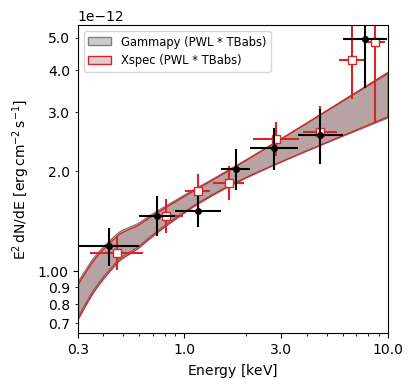

In [28]:
def calculate_assym_errors(cen,err,unit = 'erg/(cm*cm*s)'):
    import astropy.units as u
    units = u.Unit(unit)
    cen = cen.to(unit).value
    err = err.to(unit).value
    ypos = cen+err
    yneg = 10**(2*np.log10(cen)-np.log10(cen+err))
    return(cen*units,yneg*units,ypos*units)


fig = plt.figure(figsize=(4, 4),dpi=100)

# Create an invisible plot to generate the axes (needs to be done once)
ax = xrt_only_model['OP313'].spectral_model.plot_error(
    [energy_edges[0],energy_edges[-1]],
    facecolor='None',
    sed_type='e2dnde'
)

# Block to draw the model with custom style
model = xrt_only_model['OP313']
ene = np.geomspace(energy_edges[0],energy_edges[-1],100)
cen,err = model.spectral_model.evaluate_error(energy=ene)*ene*ene
cen,yneg,ypos = calculate_assym_errors(cen,err)
ax.fill_between(ene,yneg,ypos,facecolor=(0,0,0,0.2),edgecolor='tab:gray',label='Gammapy (PWL * TBabs)')
xlims = ax.get_xlim()
ylims = ax.get_ylim()

# Block to draw the model with custom style
model = xspec_model
ene = np.geomspace(energy_edges[0],energy_edges[-1],100)
cen,err = model.spectral_model.evaluate_error(energy=ene)*ene*ene
cen,yneg,ypos = calculate_assym_errors(cen,err)
ax.fill_between(ene,yneg ,ypos,facecolor=(0.4,0,0,0.2),edgecolor='tab:red',label='Xspec (PWL * TBabs)')
xlims = ax.get_xlim()
ylims = ax.get_ylim()

xrt_only_points.plot(
    ax=ax, color="black", sed_type='e2dnde',
    zorder=2,
)

xspec_points = xspec_points[xspec_points['e2dnde']>0]
x,xerrn,xerrp = calculate_assym_errors(xspec_points['energy'],xspec_points['energy_err'],unit='keV')
y,yerrn,yerrp = calculate_assym_errors(xspec_points['e2dnde'],xspec_points['e2dnde_err'],unit='erg/cm2/s')

ax.errorbar(
    x = x,
    xerr = [x-xerrn,xerrp-x],
    y = y,
    yerr = [y-yerrn,yerrp-y],
    ls='None',
    marker='s',
    color='tab:red',
    mfc='white',
    zorder=1,
)
    

#ax.set_title('Swift-XRT analysis')
ax.legend(fontsize='small')
#ax.ticklabel_format(useOffset=True)
from matplotlib.ticker import ScalarFormatter
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(ScalarFormatter()) 
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,10))   # <--- no error
ax.ticklabel_format(axis='x', style='plain')
ax.set_xticks([0.3,1.0,3.0,10.0])
ax.set_ylabel('$\mathrm{E^2\,dN/dE}$ $\mathrm{[erg\,cm^{-2}\,s^{-1}]}$')

!mkdir -p {basedir}/Figures/MJD60373/Swift-XRT/
fig.savefig(f'{basedir}/Figures/MJD60373/Swift-XRT/BestFit_Swift-XRT_xspec_gammapy.pdf',bbox_inches='tight')

## Compare parameter contours

In [29]:
xspec_cstat = Table.read(f"{datasetdir}/xspec/stat_contours.dat",
                   format='ascii.no_header',
                   names=['cstat','delta_cstat','i_index','index','i_norm','norm'])

gammapy_cstat_1sigma = xrt_only_fit.stat_contour(
    datasets=xrt_datasets,
    x=xrt_datasets.parameters["index"],
    y=xrt_datasets.parameters["amplitude"],
    numpoints=50,
    sigma=1,
)
gammapy_cstat_2sigma = xrt_only_fit.stat_contour(
    datasets=xrt_datasets,
    x=xrt_datasets.parameters["index"],
    y=xrt_datasets.parameters["amplitude"],
    numpoints=50,
    sigma=2,
)

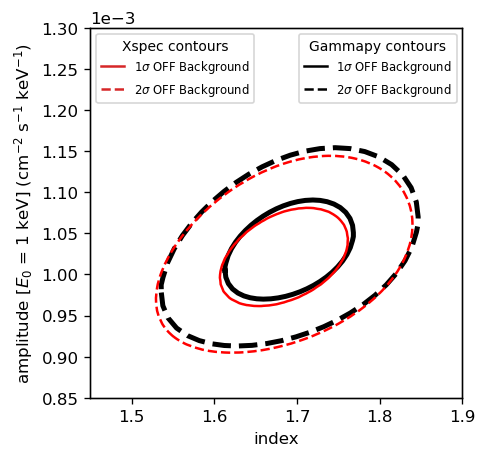

In [30]:
from scipy.stats import chi2
from astropy.table import Table
import matplotlib.lines as mlines

fig, ax = plt.subplots(figsize=(4,4),dpi=120)
ax2 = ax.twinx()

ax.plot(list(gammapy_cstat_1sigma.values())[0],list(gammapy_cstat_1sigma.values())[1],
         color='black',
         linestyle='solid',
         linewidth=3,
)
ax.plot(list(gammapy_cstat_2sigma.values())[0],list(gammapy_cstat_2sigma.values())[1],
         color='black',
         linestyle='dashed',
         linewidth=3,
)
ax.tricontour(xspec_cstat['index'],xspec_cstat['norm'],xspec_cstat['delta_cstat'],
               levels = [chi2.ppf(chi2.cdf(k,df=1), df=1) for k in [1,4]],
               colors='red',
               linestyles=['solid','dashed'],
               linewidths=1.5,
)

# Custom legend entries for ellipses
gammapy_1sigma = mlines.Line2D([], [], color='black', linestyle='solid', label='1$\\sigma$ OFF Background')
gammapy_2sigma = mlines.Line2D([], [], color='black', linestyle='dashed', label='2$\\sigma$ OFF Background')
native_1sigma = mlines.Line2D([], [], color='C3', linestyle='solid', label='1$\\sigma$ OFF Background')
native_2sigma = mlines.Line2D([], [], color='C3', linestyle='dashed', label='2$\\sigma$ OFF Background')
ax.add_artist(gammapy_1sigma)
ax.add_artist(gammapy_2sigma)
ax2.add_artist(native_1sigma)
ax2.add_artist(native_2sigma)

ax.set_ylim([0.85e-3,1.3e-3])
ax.set_xlim([1.45,1.9])
ax2.set_ylim(ax.get_ylim())
ax2.set_xlim(ax.get_xlim())
ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# Set labels and legend
ax.set_xlabel('index')
ax.set_ylabel('amplitude [$E_0$ = 1 keV] (cm$^{-2}$ s$^{-1}$ keV$^{-1}$)')


legend1 = ax.legend(ncol=1,fontsize='7', loc='upper right', title=r'Gammapy contours',
                    title_fontsize='small')
legend2 = ax2.legend(ncol=1,fontsize='7', loc='upper left', title=r'Xspec contours',
                     title_fontsize='small')

#ax.set_title('Swift-XRT best-fit parameters (PWL)')
!mkdir -p {basedir}/Figures/MJD60373/Swift-XRT/
fig.savefig(f'{basedir}/Figures/MJD60373/Swift-XRT/StatContours_Swift-XRT__xspec_gammapy.pdf',bbox_inches='tight')

In [31]:
xspec_model

SkyModel(spatial_model=None, spectral_model=<gammapy.modeling.models.spectral.CompoundSpectralModel object at 0x7f7416d57c10>)temporal_model=None)

In [32]:
xrt_only_model['OP313'].spectral_model

# Swift-UVOT

(Gammapy vs conversion mag->e2dnde)

In [74]:
basedir = os.path.abspath("../")
datasetdir  = f"{basedir}/UVOT/MJD60373/"

## Native analysis (parse uvotsource reports generated by uvot2pha)

In [75]:
import re

reports = glob.glob(f"{datasetdir}/uvot_source_reports/sw*sk.report.log")
NativeAnalysis = Table(names=["fname","freq","e2dnde","e2dnde_stat","e2dnde_syst","e2dnde_tot"],
                       units=["","Hz","erg cm-2 s-1","erg cm-2 s-1","erg cm-2 s-1","erg cm-2 s-1"],
                       dtype=["str","float","float","float","float","float"])

for fname in reports:

    block_start = "uvotsource: Flux density [mJy at "
    block_stop  = "uvotsource: shell"
    with open(fname) as f:
        input_string = f.read().split(block_start)[-1].split(block_stop)[0]
        
        # Define the regular expressions to extract the required values
        frequency_pattern = r'(\d+\.\d+) x 10\^(\d+) Hz'
        source_pattern = r'Source:\s*([\d.]+) \+\/\- ([\d.]+) \(stat\) \+\/\- ([\d.]+) \(sys\) x 10\^(-?\d+)'
        
        # Find frequency
        frequency_match = re.search(frequency_pattern, input_string)
        frequency_value = float(frequency_match.group(1))
        frequency_exponent = int(frequency_match.group(2))
        frequency = frequency_value * 10**frequency_exponent
        
        # Find source flux, statistical error, systematic error, and multiplier
        source_match = re.search(source_pattern, input_string.split("\n")[1].lstrip(" "))
        source_flux = float(source_match.group(1))
        stat_error = float(source_match.group(2))
        syst_error = float(source_match.group(3))
        multiplier = 10**int(source_match.group(4))
        
        source_flux*=multiplier
        stat_error*=multiplier
        syst_error*=multiplier
        
        source_flux = source_flux*u.Unit("mJy")
        stat_error  = stat_error*u.Unit("mJy")
        syst_error  = syst_error*u.Unit("mJy")
        frequency   = frequency*u.Unit("Hz")
        
        e2dnde = (source_flux*frequency).to('erg cm-2 s-1')
        e2dnde_stat = (stat_error*frequency).to('erg cm-2 s-1')
        e2dnde_syst = (syst_error*frequency).to('erg cm-2 s-1')
        e2dnde_tot  = ((e2dnde_stat**2 + e2dnde_syst**2)**0.5)
        
        NativeAnalysis.add_row([fname.split("/")[-1].split("_sk.report.log")[0],
                                frequency,e2dnde,e2dnde_stat,e2dnde_syst,e2dnde_tot])

NativeAnalysis.sort(keys='freq')

## Gammapy

In [76]:
def get_average_energy(exp):
    ene_data = exp.geom.axes['energy_true'].center
    exp_data = exp.data.flatten()
    return (ene_data * exp_data).sum().to('eV')/(exp_data.sum())

# load the dataset and models (without hydrogen-absorption), assuming we start from the Notebooks directory
uvot_datasets = Datasets.read(f"{datasetdir}/dataset.yaml")
average_energies = [get_average_energy(d.exposure) for d in uvot_datasets]
sortedby_energy  = np.argsort([e.value for e in average_energies])
uvot_datasets.models = list(Models.read(f"{datasetdir}/models.yaml"))
# sorted by energy
uvot_datasets = Datasets([list(uvot_datasets)[k] for k in sortedby_energy])

extinction_model = get_xredden_template_model(f"{basedir}/Models/xredden_tau_factor_vs_EBV_energy.ecsv",
                                              srcname='OP313')

extinction_model.parameters['ebv'].frozen = True
uvot_datasets.models[0].spectral_model *= extinction_model

/home/mnievas/anaconda/envs/ciaoxray_devel/lib/python3.11/site-packages/gammapy/utils/scripts.py:66: UserWarning: Checksum verification failed.
  warnings.warn("Checksum verification failed.", UserWarning)


In [77]:
# Define a fit
uvot_only_fit    = Fit(store_trace=True)
uvot_only_result = uvot_only_fit.run(uvot_datasets)
# we make a copy here for later comparisons
uvot_only_model = uvot_datasets.models.copy()
# spectral points
energy_edge_pairs = [get_dataset_energy_edges(d) for d in uvot_datasets]
uvot_only_fpe     = [FluxPointsEstimator(energy_edges=edges, source="OP313") for edges in energy_edge_pairs]
uvot_only_points  = [uvot_only_fpe[k].run(datasets=d) for k,d in enumerate(uvot_datasets)]

In [78]:
gammapy_fluxtable = vstack([d.to_table(sed_type='e2dnde') for d in uvot_only_points])

gammapy_e2dnde  = np.transpose([gammapy_fluxtable['e2dnde'].to('erg cm-2 s-1'),
                                gammapy_fluxtable['e2dnde_err'].to('erg cm-2 s-1')])

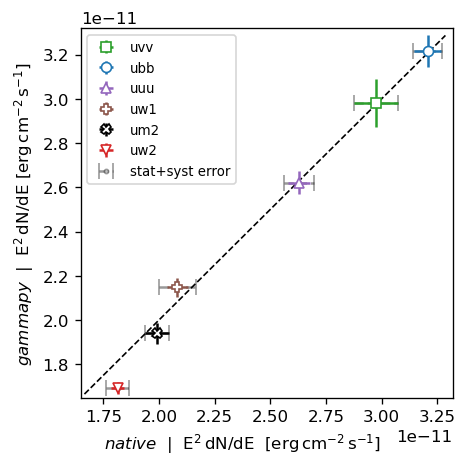

In [79]:
fig,ax = plt.subplots(figsize=(4,4),dpi=120)

colors = {
    'ubb': 'tab:blue',
    'uw1': 'C5',
    'uvv': 'C2',
    'uw2': 'C3',
    'um2': 'black',
    'uuu': 'C4',
}

markers = {
    'ubb': 'o',
    'uw1': 'P',
    'uvv': 's',
    'uw2': 'v',
    'um2': 'X',
    'uuu': '^',
}

filters = []
for k,p in enumerate(NativeAnalysis):
    lbl = NativeAnalysis['fname'][k][-3:]
    if lbl not in filters:
        filters.append(lbl)
    else:
        lbl = None
    ax.errorbar(
        x=NativeAnalysis['e2dnde'][k],
        xerr=NativeAnalysis['e2dnde_stat'][k],
        y=gammapy_fluxtable['e2dnde'].to('erg cm-2 s-1').value[k],
        yerr=gammapy_fluxtable['e2dnde_err'].to('erg cm-2 s-1').value[k],
        ls='None',mfc='white',ms=6.,zorder=20,
        #color='0.5'
        color=colors[NativeAnalysis['fname'][k][-3:]],
        label=lbl,
        marker=markers[NativeAnalysis['fname'][k][-3:]],
    )

errorbar = ax.errorbar(
    x=NativeAnalysis['e2dnde'],
    xerr=NativeAnalysis['e2dnde_tot'],
    y=gammapy_e2dnde[:,0],
    #yerr=gammapy_e2dnde[:,1],
    ls='None',marker='.',mfc='white',ms=5., markeredgewidth=1,
    color='black',alpha=0.4,zorder=0,capsize=5,
    label='stat+syst error'
)
errorbar[-1][0].set_linestyle('dashed')

xmin,xmax = (min(min(NativeAnalysis['e2dnde']-NativeAnalysis['e2dnde_tot']),min(gammapy_e2dnde[:,0]-gammapy_e2dnde[:,1])),
             max(max(NativeAnalysis['e2dnde']+NativeAnalysis['e2dnde_tot']),max(gammapy_e2dnde[:,0]+gammapy_e2dnde[:,1])))

ax.plot([xmin,xmax],
        [xmin,xmax],
        color='black', lw=1, ls='dashed',
       )
ax.set_xlim([xmin*0.99,xmax*1.01])
ax.set_ylim([xmin*0.99,xmax*1.01])
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel('$native$  |  $\mathrm{E^2\,dN/dE}$  $\mathrm{[erg\,cm^{-2}\,s^{-1}]}$'+' '*10)
ax.set_ylabel('$gammapy$  |  $\mathrm{E^2\,dN/dE}$ $\mathrm{[erg\,cm^{-2}\,s^{-1}]}$')

ax.legend(fontsize='8')
!mkdir -p {basedir}/Figures/MJD60373/Swift-UVOT/
fig.savefig(f"{basedir}/Figures/MJD60373/Swift-UVOT/ValidationFilterPhotometry_UVOT.pdf",bbox_inches="tight")

/tmp/ipykernel_1834663/1003906507.py:9: RuntimeWarning: divide by zero encountered in divide
  return (h.to('eV s').value * c.to('AA s-1').value * 1e9) / lambda_AA  # energy in eV
/tmp/ipykernel_1834663/1003906507.py:9: RuntimeWarning: divide by zero encountered in divide
  return (h.to('eV s').value * c.to('AA s-1').value * 1e9) / lambda_AA  # energy in eV


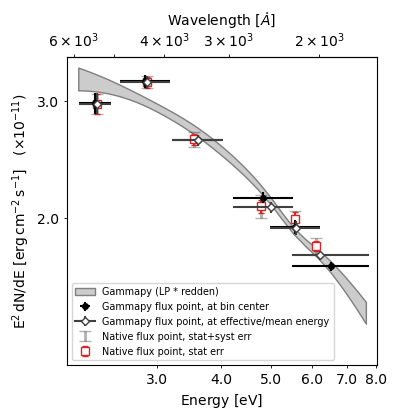

In [80]:
plt.figure(figsize=(4, 4),dpi=100)

emin = min([min(pair) for pair in energy_edge_pairs]).to('eV')
emax = max([max(pair) for pair in energy_edge_pairs]).to('eV')

# Create an invisible plot to generate the axes (needs to be done once)
ax = uvot_only_model['OP313'].spectral_model.plot_error(
    [emin,emax],
    facecolor='None',
    sed_type='e2dnde'
)

# Block to draw the model with custom style
model = uvot_only_model['OP313']
ene = np.geomspace(emin,emax,100)
cen,err = model.spectral_model.evaluate_error(energy=ene)*ene*ene
cen,yneg,ypos = calculate_assym_errors(cen,err)
ax.fill_between(ene,yneg,ypos,facecolor=(0,0,0,0.2),edgecolor='tab:gray',label='Gammapy (LP * redden)')
xlims = ax.get_xlim()
ylims = ax.get_ylim()

for k,point in enumerate(uvot_only_points):
    point.plot(
        ax=ax, color="black", sed_type='e2dnde',
        label='Gammapy flux point, at bin center' if k==0 else '',
    )
    #ref_energy = get_dataset_energy_edges_from_aeff_integral(uvot_datasets[k],factor=0.5)[0]
    ref_energy = get_weighted_mean_energy_from_aeff(uvot_datasets[k])
    ref_dnde = uvot_only_model['OP313'].spectral_model(ref_energy)[0]
    ax.errorbar(
        x = [ref_energy.to('eV').value],
        xerr = [[(ref_energy-point.energy_min[0]).to('eV').value],[(point.energy_max[0]-ref_energy).to('eV').value]],
        y = [(point.norm.data.flatten()[0]*ref_dnde*ref_energy*ref_energy).to('erg cm-2 s-1').value],
        yerr = [(point.norm_err.data.flatten()[0]*ref_dnde*ref_energy*ref_energy).to('erg cm-2 s-1').value],
        color='0.25',mfc='white',marker='D',ms=4,label='Gammapy flux point, at effective/mean energy' if k==0 else '',
    )
        
errorbar = ax.errorbar(
    y=NativeAnalysis['e2dnde'],
    yerr=NativeAnalysis['e2dnde_tot'],
    x=NativeAnalysis['freq']*4.13566553853599E-15,
    #yerr=gammapy_e2dnde[:,1],
    ls='None',
    marker='s',ms=0,
    color='black',
    mfc='white',
    zorder=1, alpha=0.3, lw=2,
    label='Native flux point, stat+syst err',capsize=4,
)
errorbar[-1][0].set_linestyle('dashed')

errorbar = ax.errorbar(
    y=NativeAnalysis['e2dnde'],
    yerr=NativeAnalysis['e2dnde_stat'],
    x=NativeAnalysis['freq']*4.13566553853599E-15,
    #yerr=gammapy_e2dnde[:,1],
    ls='None',
    marker='s',
    color='tab:red',
    mfc='white',
    zorder=1,
    label='Native flux point, stat err',capsize=2,
)

ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.set_xlim(0.95*emin,emax*1.05)
ax.set_ylim(1.2e-11,3.5e-11)
#ax.set_title('Swift-UVOT analysis')
ax.set_ylabel('$\mathrm{E^2\,dN/dE}$ $\mathrm{[erg\,cm^{-2}\,s^{-1}]}\quad (\\times 10^{-11})$')
ax.legend(loc=3,fontsize='x-small',)

ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', useOffset=True)
ax.yaxis.get_offset_text().set_visible(False)
ax.yaxis.get_major_formatter().set_powerlimits((-11, -11))

# Create a secondary x-axis for wavelength
secax = ax.secondary_xaxis('top', functions=(energy_to_wavelength_eV, wavelength_to_energy_eV))
secax.set_xlabel('Wavelength [$\mathring{A}$]')
secax.xaxis.set_major_formatter(mticker.ScalarFormatter())
secax.ticklabel_format(axis='x', style='plain')

!mkdir -p {basedir}/Figures/MJD60373/Swift-UVOT/
plt.savefig(f'{basedir}/Figures/MJD60373/Swift-UVOT/ValidationFilterSED_UVOT.pdf',bbox_inches='tight')

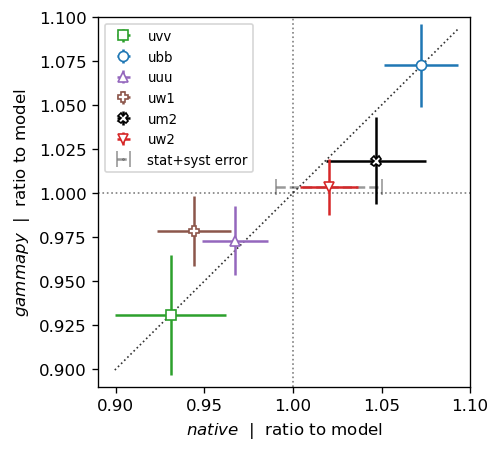

In [81]:
fig,ax = plt.subplots(figsize=(4,4),dpi=120)

colors = {
    'ubb': 'tab:blue',
    'uw1': 'C5',
    'uvv': 'C2',
    'uw2': 'C3',
    'um2': 'black',
    'uuu': 'C4',
}

markers = {
    'ubb': 'o',
    'uw1': 'P',
    'uvv': 's',
    'uw2': 'v',
    'um2': 'X',
    'uuu': '^',
}

ref_energy_native = NativeAnalysis['freq'].value*4.13566553853599E-15*u.eV
ref_dnde_native   = uvot_only_model['OP313'].spectral_model(ref_energy_native)
ref_e2dnde_native = (ref_dnde_native*ref_energy_native*ref_energy_native).to('erg cm-2 s-1')

ref_energy_gammapy = u.Quantity([get_dataset_energy_edges_from_aeff_integral(d,factor=0.5)[0] for d in uvot_datasets])
ref_dnde_gammapy   = uvot_only_model['OP313'].spectral_model(ref_energy_gammapy)
ref_e2dnde_gammapy = (ref_dnde_gammapy*ref_energy_gammapy*ref_energy_gammapy).to('erg cm-2 s-1')

filters = []
for k,p in enumerate(NativeAnalysis):
    lbl = NativeAnalysis['fname'][k][-3:]
    if lbl not in filters:
        filters.append(lbl)
    else:
        lbl = None
    ax.errorbar(
        x=NativeAnalysis['e2dnde'][k]/ref_e2dnde_native[k],
        xerr=NativeAnalysis['e2dnde_stat'][k]/ref_e2dnde_native[k],
        y=uvot_only_points[k].norm.data.flatten(),
        yerr=uvot_only_points[k].norm_err.data.flatten(),
        ls='None',mfc='white',ms=6.,zorder=20,
        #color='0.5'
        color=colors[NativeAnalysis['fname'][k][-3:]],
        label=lbl,
        marker=markers[NativeAnalysis['fname'][k][-3:]],
    )

errorbar = ax.errorbar(
    x=NativeAnalysis['e2dnde'][k]/ref_e2dnde_native[k],
    xerr=NativeAnalysis['e2dnde_tot'][k]/ref_e2dnde_native[k],
    y=uvot_only_points[k].norm.data.flatten(),
    #yerr=gammapy_e2dnde[:,1],
    ls='None',marker='.',mfc='white',ms=1., markeredgewidth=1,
    color='black',alpha=0.4,zorder=0,capsize=5,
    label='stat+syst error'
)
errorbar[-1][0].set_linestyle('dashed')

ax.set_xlim([0.89,1.1])
ax.set_ylim([0.89,1.1])

ax.axvline(1,color='black',lw=1,ls='dotted',zorder=-10,alpha=0.5)
ax.axhline(1,color='black',lw=1,ls='dotted',zorder=-10,alpha=0.5)

ax.set_xlabel('$native$  |  ratio to model')
ax.set_ylabel('$gammapy$  |  ratio to model')

xmin,xmax = (min((NativeAnalysis['e2dnde']-NativeAnalysis['e2dnde_tot'])/(ref_e2dnde_native)),
             max((NativeAnalysis['e2dnde']+NativeAnalysis['e2dnde_tot'])/ref_e2dnde_native))

ax.plot([xmin,xmax],
        [xmin,xmax],
        color='black', lw=1, ls='dotted',alpha=0.8,
       )

ax.legend(fontsize='8',ncol=1)
!mkdir -p {basedir}/Figures/MJD60373/Swift-UVOT/
fig.savefig(f"{basedir}/Figures/MJD60373/Swift-UVOT/ValidationFilterPhotometry_UVOT.pdf",bbox_inches="tight")

# Liverpool IO:O

(Gammapy vs conversion mag->e2dnde)

## Native analysis

In [82]:
basedir = os.path.abspath("../")
datasetdir  = f"{basedir}/Liverpool_IOO/MJD60373/"

In [83]:
from astropy.table import vstack

NativePhotometryTable = Table.read(f"{datasetdir}/PhotometryTable.ecsv",format='ascii.ecsv')
for col in ['e2dnde_obs','e2dnde_obs_err','filter_center','excess_err','excess']:
    NativePhotometryTable[col] = np.asarray(NativePhotometryTable[col].value,dtype=float)
NativePhotometryTable['e2dnde_obs_stat'] = NativePhotometryTable['e2dnde_obs']*NativePhotometryTable['excess_err']/NativePhotometryTable['excess']


native_datasets = np.asarray([[float(n['e2dnde_obs']),
                               float(n['e2dnde_obs_err'])]\
                              for n in NativePhotometryTable])
native_datasets_nozperr = np.asarray([[float(n['e2dnde_obs']),
                                       float(n['e2dnde_obs'])*(float(n['excess_err'])/float(n['excess']))]\
                                       for n in NativePhotometryTable])


## Gammapy

In [84]:
# load the dataset and models (without hydrogen-absorption), assuming we start from the Notebooks directory
liverpool_datasets = Datasets.read(f"{datasetdir}/dataset.yaml")
liverpool_datasets.models = list(Models.read(f"{datasetdir}/models.yaml"))

# Stack datasets ?
unique_bands = np.unique([d.name.split('_h_e_')[0] for d in liverpool_datasets])
liverpool_datasets_stacked = Datasets([Datasets([d for d in liverpool_datasets if band in d.name]).stack_reduce(name=band) for band in unique_bands])
liverpool_datasets_stacked.models = list(Models.read(f"{datasetdir}/models.yaml"))

extinction_model = get_xredden_template_model(
    f"{basedir}/Models/xredden_tau_factor_vs_EBV_energy.ecsv",
    srcname='OP313'
)
extinction_model.parameters['ebv'].frozen = True

liverpool_datasets.models[0].spectral_model *= extinction_model
liverpool_datasets_stacked.models[0].spectral_model *= extinction_model

/home/mnievas/anaconda/envs/ciaoxray_devel/lib/python3.11/site-packages/gammapy/utils/scripts.py:66: UserWarning: Checksum verification failed.
  warnings.warn("Checksum verification failed.", UserWarning)


In [85]:
# Define a fit
liverpool_only_fit     = Fit(store_trace=True)
liverpool_only_result  = liverpool_only_fit.run(liverpool_datasets)
# we make a copy here for later comparisons
liverpool_only_model   = liverpool_datasets.models.copy()
energy_edge_pairs      = [get_dataset_energy_edges(d) for d in liverpool_datasets]
# correct the systematic uncertainty?
liverpool_only_fpe     = [FluxPointsEstimator(energy_edges=energy_edge_pairs[k], source='OP313') for k,d in enumerate(liverpool_datasets)]
    
liverpool_only_points  = [liverpool_only_fpe[k].run(datasets=d) for k,d in enumerate(liverpool_datasets)]

In [86]:
# Define a fit
liverpool_only_fit_s     = Fit(store_trace=True)
liverpool_only_result_s  = liverpool_only_fit_s.run(liverpool_datasets_stacked)
# we make a copy here for later comparisons
liverpool_only_model_s   = liverpool_datasets_stacked.models.copy()
energy_edge_pairs_s      = [get_dataset_energy_edges(d) for d in liverpool_datasets_stacked]
# correct the systematic uncertainty?
liverpool_only_fpe_s     = [FluxPointsEstimator(energy_edges=energy_edge_pairs_s[k], source='OP313') for k,d in enumerate(liverpool_datasets_stacked)]
    
liverpool_only_points_s  = [liverpool_only_fpe_s[k].run(datasets=d) for k,d in enumerate(liverpool_datasets_stacked)]

In [87]:
gammapy_fluxtable = vstack([d.to_table(sed_type='e2dnde') for d in liverpool_only_points])

gammapy_e2dnde  = np.transpose([gammapy_fluxtable['e2dnde'].to('erg cm-2 s-1'),
                                gammapy_fluxtable['e2dnde_err'].to('erg cm-2 s-1')])

In [88]:
# Corrected for systematics
intrinsic_model  = liverpool_only_model[0].spectral_model.model1.model2
absorption_model = liverpool_only_model[0].spectral_model.model2
corrected_model  = (intrinsic_model * absorption_model)

liverpool_corrected = [
    point.from_table(point.to_table().copy(),reference_model=corrected_model) \
    for point in liverpool_only_points
]

gammapy_fluxtable_corr = vstack([
    d.to_table(sed_type='e2dnde') for d in liverpool_corrected
])

gammapy_e2dnde_corr  = np.transpose([
    gammapy_fluxtable_corr['e2dnde'].to('erg cm-2 s-1'),
    gammapy_fluxtable_corr['e2dnde_err'].to('erg cm-2 s-1')
])

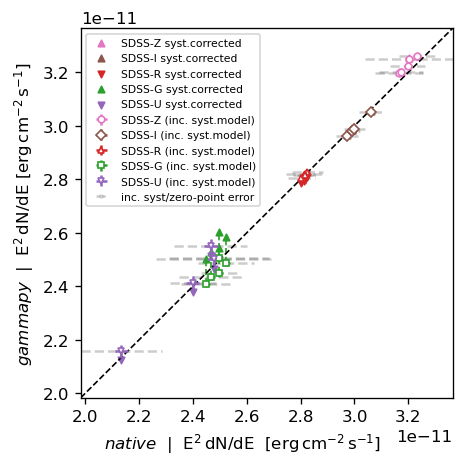

In [91]:
fig,ax = plt.subplots(figsize=(4,4),dpi=120)

colors = {
    'SDSS-Z': 'tab:pink',
    'SDSS-I': 'C5',
    'SDSS-G': 'C2',
    'SDSS-R': 'C3',
    'SDSS-U': 'C4',
}

markers={
    'SDSS-Z': 'o',
    'SDSS-I': 'D',
    'SDSS-G': 's',
    'SDSS-R': '^',
    'SDSS-U': 'v',
}

filters = []
for k,p in enumerate(native_datasets):
    lbl = NativePhotometryTable['filter'][k]
    if lbl not in filters:
        filters.append(lbl)
    else:
        lbl = None
    if lbl is not None:
        lbl += ' (inc. syst.model)'
    
    ax.errorbar(
        x=NativePhotometryTable['e2dnde_obs'][k],
        xerr=NativePhotometryTable['e2dnde_obs_stat'][k],
        y=gammapy_fluxtable['e2dnde'].to('erg cm-2 s-1').value[k],
        yerr=gammapy_fluxtable['e2dnde_err'].to('erg cm-2 s-1').value[k],
        ls='None',mfc='white',ms=4.,zorder=20,
        #color='0.5'
        color=colors[NativePhotometryTable['filter'][k]],
        label=lbl,
        marker=markers[NativePhotometryTable['filter'][k]],
    )
    
filters = []
for k,p in enumerate(native_datasets):
    lbl = NativePhotometryTable['filter'][k]
    if lbl not in filters:
        filters.append(lbl)
        lab = f'{lbl} syst.corrected'
    else:
        lab=''
        
    ax.vlines(
        x=NativePhotometryTable['e2dnde_obs'][k],
        ymin=min(gammapy_fluxtable_corr['e2dnde'].to('erg cm-2 s-1').value[k],gammapy_fluxtable['e2dnde'].to('erg cm-2 s-1').value[k]),
        ymax=max(gammapy_fluxtable_corr['e2dnde'].to('erg cm-2 s-1').value[k],gammapy_fluxtable['e2dnde'].to('erg cm-2 s-1').value[k]),
        color=colors[NativePhotometryTable['filter'][k]],ls='dashed',lw=1,
    )
    ax.scatter(
        x=NativePhotometryTable['e2dnde_obs'][k],
        y=gammapy_fluxtable_corr['e2dnde'].to('erg cm-2 s-1').value[k],
        color=colors[NativePhotometryTable['filter'][k]],
        marker='^' if gammapy_fluxtable_corr['e2dnde'].to('erg cm-2 s-1').value[k]>gammapy_fluxtable['e2dnde'].to('erg cm-2 s-1').value[k] else 'v',
        s=15,
        label=lab,
    )

errorbar = ax.errorbar(
    x=native_datasets[:,0],
    xerr=native_datasets[:,1],
    y=gammapy_e2dnde[:,0],
    #yerr=gammapy_e2dnde[:,1],
    ls='None',marker='.',mfc='white',ms=4., markeredgewidth=0.5,
    color='black',alpha=0.2,zorder=0,
    label='inc. syst/zero-point error'
)

errorbar[-1][0].set_linestyle('dashed')

xmin,xmax = (min(min(native_datasets[:,0]-native_datasets[:,1]),min(gammapy_e2dnde[:,0]-gammapy_e2dnde[:,1])),
             max(max(native_datasets[:,0]+native_datasets[:,1]),max(gammapy_e2dnde[:,0]+gammapy_e2dnde[:,1])))

ax.plot([xmin,xmax],
        [xmin,xmax],
        color='black', lw=1, ls='dashed',
       )
ax.set_xlim([xmin,xmax])
ax.set_ylim([xmin,xmax])
ax.set_xlabel('$native$  |  $\mathrm{E^2\,dN/dE}$  $\mathrm{[erg\,cm^{-2}\,s^{-1}]}$'+' '*10)
ax.set_ylabel('$gammapy$  |  $\mathrm{E^2\,dN/dE}$ $\mathrm{[erg\,cm^{-2}\,s^{-1}]}$')

ax.legend(fontsize='6.5',ncol=1)
!mkdir -p {basedir}/Figures/MJD60373/Liverpool/
fig.savefig(f"{basedir}/Figures/MJD60373/Liverpool/ValidationFilterPhotometry_LT.pdf",bbox_inches="tight")

In [92]:
averaged_phot = None

for filt in np.unique(NativePhotometryTable['filter']):
    sel = NativePhotometryTable[NativePhotometryTable['filter']==filt].copy()
    sel.remove_columns(['fname','dname','n_cal_stars','n_cal_stars_filt','r_on','r_off_1','r_off_2'])
    average = sel[0]
    e2dnde,err_inv = np.average(a=sel['e2dnde_obs'],weights=1./sel['e2dnde_obs_stat']**2,returned=True)
    e2dnde_err_stat = 1./np.sqrt(err_inv)
    e2dnde_err_tot  = np.sqrt(np.max(sel['e2dnde_obs_err']-sel['e2dnde_obs_stat'])**2 + e2dnde_err_stat**2)
    average['e2dnde_obs'] = e2dnde
    average['e2dnde_obs_err'] = e2dnde_err_tot
    average['e2dnde_obs_stat'] = e2dnde_err_stat
    try:
        averaged_phot = vstack([averaged_phot,average])
    except:
        averaged_phot = average

/tmp/ipykernel_1834663/1003906507.py:9: RuntimeWarning: divide by zero encountered in divide
  return (h.to('eV s').value * c.to('AA s-1').value * 1e9) / lambda_AA  # energy in eV
/tmp/ipykernel_1834663/1003906507.py:9: RuntimeWarning: divide by zero encountered in divide
  return (h.to('eV s').value * c.to('AA s-1').value * 1e9) / lambda_AA  # energy in eV


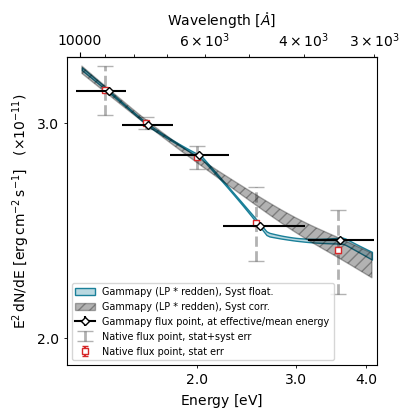

In [93]:
plt.figure(figsize=(4, 4),dpi=100)

emin = min([min(pair) for pair in energy_edge_pairs_s]).to('eV')
emax = max([max(pair) for pair in energy_edge_pairs_s]).to('eV')

# Create an invisible plot to generate the axes (needs to be done once)
ax = liverpool_only_model_s['OP313'].spectral_model.plot_error(
    [emin,emax],
    facecolor='None',
    sed_type='e2dnde'
)

corrected_model = liverpool_only_model_s['OP313'].spectral_model
corrected_model = corrected_model.model1.model2*corrected_model.model2

# Block to draw the model with custom style
model = liverpool_only_model_s['OP313']
ene = np.geomspace(emin,emax,100)
cen,err = model.spectral_model.evaluate_error(energy=ene)*ene*ene
cen,yneg,ypos = calculate_assym_errors(cen,err)
ax.fill_between(ene,yneg,ypos,facecolor=(0.1,0.5,0.6,0.3),edgecolor=(0.1,0.5,0.6,1),label='Gammapy (LP * redden), Syst float.')
xlims = ax.get_xlim()
ylims = ax.get_ylim()

# Block to draw the model with custom style
ene = np.geomspace(emin,emax,100)
cen,err = corrected_model.evaluate_error(energy=ene)*ene*ene
cen,yneg,ypos = calculate_assym_errors(cen,err)
ax.fill_between(ene,yneg,ypos,facecolor=(0,0,0,0.3),hatch='///',edgecolor=(0,0,0,0.3),label='Gammapy (LP * redden), Syst corr.')
xlims = ax.get_xlim()
ylims = ax.get_ylim()

for k,point in enumerate(liverpool_only_points_s):
    #point.plot(
    #    ax=ax, color="black", sed_type='e2dnde',
    #    label='Gammapy, flux points' if k==0 else '',
    #)
    ref_energy = get_dataset_energy_edges_from_aeff_integral(liverpool_datasets_stacked[k],factor=0.5)[0]
    ref_dnde = liverpool_only_model_s['OP313'].spectral_model(ref_energy)[0]
    ax.errorbar(
        x = [ref_energy.to('eV').value],
        xerr = [[(ref_energy-point.energy_min[0]).to('eV').value],[(point.energy_max[0]-ref_energy).to('eV').value]],
        y = [(point.norm.data.flatten()[0]*ref_dnde*ref_energy*ref_energy).to('erg cm-2 s-1').value],
        yerr = [(point.norm_err.data.flatten()[0]*ref_dnde*ref_energy*ref_energy).to('erg cm-2 s-1').value],
        color='0',mfc='white',marker='D',ms=4,label='Gammapy flux point, at effective/mean energy' if k==0 else '',
    )

errorbar = ax.errorbar(
    y=averaged_phot['e2dnde_obs'].value,
    yerr=averaged_phot['e2dnde_obs_err'].value,
    x=averaged_phot['filter_center'].value*4.13566553853599E-15,
    #yerr=gammapy_e2dnde[:,1],
    ls='None',
    marker='s',ms=0,
    color='black', alpha=0.3, lw=2,
    mfc='white',
    zorder=1,
    label='Native flux point, stat+syst err',capsize=6,
)

errorbar[-1][0].set_linestyle('dashed')

errorbar = ax.errorbar(
    y=averaged_phot['e2dnde_obs'].value,
    yerr=averaged_phot['e2dnde_obs_stat'].value,
    x=averaged_phot['filter_center'].value*4.13566553853599E-15,
    #yerr=gammapy_e2dnde[:,1],
    ls='None',
    marker='s',ms=4,
    color='tab:red',
    mfc='white',
    zorder=1,
    label='Native flux point, stat err',capsize=2,
)

ax.set_xlim(0.94*emin,emax*1.02)
ax.set_ylim(1.9e-11,3.4e-11)
#ax.set_title('Liverpool IO:O analysis')
ax.set_ylabel('$\mathrm{E^2\,dN/dE}$ $\mathrm{[erg\,cm^{-2}\,s^{-1}]}\quad (\\times 10^{-11})$')
ax.legend(loc=3,fontsize='x-small',)

ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())

ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', useOffset=True)
ax.yaxis.get_offset_text().set_visible(False)
ax.yaxis.get_major_formatter().set_powerlimits((-11, -11))

# Create a secondary x-axis for wavelength
secax = ax.secondary_xaxis('top', functions=(energy_to_wavelength_eV, wavelength_to_energy_eV))
secax.set_xlabel('Wavelength [$\mathring{A}$]')
secax.xaxis.set_major_formatter(mticker.ScalarFormatter())
secax.ticklabel_format(axis='x', style='plain')

!mkdir -p {basedir}/Figures/MJD60373/Liverpool/
plt.savefig(f'{basedir}/Figures/MJD60373/Liverpool/ValidationFilterSED_LT.pdf',bbox_inches='tight')
plt.savefig(f'{basedir}/Figures/MJD60373/Liverpool/ValidationFilterSED_LT.png',bbox_inches='tight')

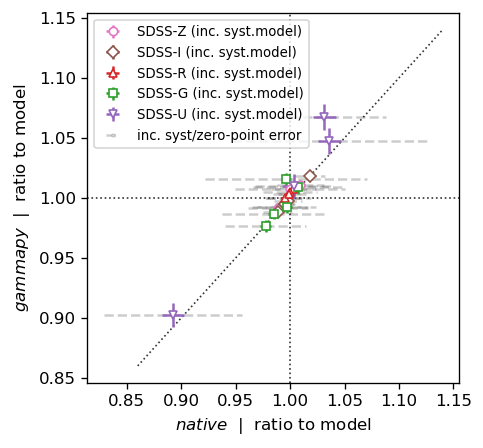

In [102]:
fig,ax = plt.subplots(figsize=(4,4),dpi=120)

colors = {
    'SDSS-Z': 'tab:pink',
    'SDSS-I': 'C5',
    'SDSS-G': 'C2',
    'SDSS-R': 'C3',
    'SDSS-U': 'C4',
}

markers={
    'SDSS-Z': 'o',
    'SDSS-I': 'D',
    'SDSS-G': 's',
    'SDSS-R': '^',
    'SDSS-U': 'v',
}

ref_energy_native = NativePhotometryTable['filter_center'].value*4.13566553853599E-15*u.eV
ref_dnde_native   = liverpool_only_model['OP313'].spectral_model(ref_energy_native)
ref_e2dnde_native = (ref_dnde_native*ref_energy_native*ref_energy_native).to('erg cm-2 s-1')

ref_energy_gammapy = u.Quantity([get_dataset_energy_edges_from_aeff_integral(d,factor=0.5)[0] for d in liverpool_datasets])
ref_dnde_gammapy   = liverpool_only_model['OP313'].spectral_model(ref_energy_gammapy)
ref_e2dnde_gammapy = (ref_dnde_gammapy*ref_energy_gammapy*ref_energy_gammapy).to('erg cm-2 s-1')

filters = []
for k,p in enumerate(native_datasets):
    lbl = NativePhotometryTable['filter'][k]
    if lbl not in filters:
        filters.append(lbl)
    else:
        lbl = None
    if lbl is not None:
        lbl += ' (inc. syst.model)'
    
    ax.errorbar(
        x=NativePhotometryTable['e2dnde_obs'][k]/ref_e2dnde_native[k],
        xerr=NativePhotometryTable['e2dnde_obs_stat'][k]/ref_e2dnde_native[k],
        y=liverpool_only_points[k].norm.data.flatten(),
        yerr=liverpool_only_points[k].norm_err.data.flatten(),
        ls='None',marker=markers[NativePhotometryTable['filter'][k]],
        mfc='white',ms=5.,zorder=20,
        #color='0.5'
        color=colors[NativePhotometryTable['filter'][k]],
        label=lbl,
    )

errorbar = ax.errorbar(
    x=native_datasets[:,0]/ref_e2dnde_native,
    xerr=native_datasets[:,1]/ref_e2dnde_native,
    y=[liverpool_only_points[k].norm.data.flatten() for k,p in enumerate(native_datasets)] ,
    #yerr=gammapy_e2dnde[:,1],
    ls='None',marker='.',mfc='white',ms=4., markeredgewidth=0.5,
    color='black',alpha=0.2,zorder=0,
    label='inc. syst/zero-point error'
)

errorbar[-1][0].set_linestyle('dashed')

#xmin,xmax = (min(min(native_datasets[:,0]-native_datasets[:,1]),min(gammapy_e2dnde[:,0]-gammapy_e2dnde[:,1])),
#             max(max(native_datasets[:,0]+native_datasets[:,1]),max(gammapy_e2dnde[:,0]+gammapy_e2dnde[:,1])))

ax.plot([0.86,1.14],
        [0.86,1.14],
        color='black', lw=1, ls='dotted',alpha=0.8,
       )
ax.axvline(1,color='black',lw=1,ls='dotted',zorder=-10,alpha=0.8)
ax.axhline(1,color='black',lw=1,ls='dotted',zorder=-10,alpha=0.8)

#ax.set_xlim([xmin,xmax])
#ax.set_ylim([xmin,xmax])
ax.set_xlabel('$native$  |  ratio to model')
ax.set_ylabel('$gammapy$  |  ratio to model')

ax.legend(fontsize='8',ncol=1)
!mkdir -p {basedir}/Figures/MJD60373/Liverpool/
fig.savefig(f"{basedir}/Figures/MJD60373/Liverpool/ValidationFilterPhotometry_LT.pdf",bbox_inches="tight")